# Setup

In [1]:
# my virtual environments are rarely properly connected to jupyter so this fixes that. 
# you prolly won't need this cell but running it won't hurt anything either
import sys
import os
current_dir = os.getcwd()  # Get the current working directory
venv_dir = os.path.join(current_dir, 'venv') 
python_version = str(sys.version_info.major) + '.' + str(sys.version_info.minor)
site_packages_path = os.path.join(venv_dir, 'lib', 'python' + python_version, 'site-packages')
sys.path.append(site_packages_path) 

# Instantiate a brand new model

In [2]:
# config file
from config import ModelConfig, TrainConfig
cfg = ModelConfig()
tcfg = TrainConfig()
print(cfg, '\n\n', tcfg)

# import the tokenizer specified by cfg
from tools import import_from_nested_path
imported_objects = import_from_nested_path(['tokenizers', cfg.tokenizer], 'tokenizer', ['get_tokenizer'])
get_tokenizer = imported_objects.get('get_tokenizer')
tokenizer = get_tokenizer(size = cfg.vocab_len)

# model modules
from modules.model import Model
model = Model(cfg).to(cfg.device)

import torch
if model.device == 'cuda':
    model = torch.compile(model) 
    # ^if this takes too long & you're debugging you can comment it out, but def leave it on for full training runs

# print the number of parameters in the model
print("\nnumber of parameters: %.2fM\n" % (model.get_num_params()/1e6,))
print(model)

ModelConfig(dim=32, device='cpu', out_weight_share=True, linear_bias=False, tokenizer='bpe_v2_tinyStories', vocab_len=512, num_layers=2, second_resid_norm=False, mlp_hidden_mult=4, mlp_nonlinearity='SiLU', mlp_gated=True, num_q_heads=2, num_kv_heads=1, head_dim=16, theta=10000, max_seq_len=64, scale_first_resid=True, norm_type='RMSNorm', norm_affine=True, norm_bias=True, eps=1e-06) 

 TrainConfig(micro_batch_size=8, grad_accum_steps=16, max_iters=20, eval_interval=5, eval_samples=1, checkpoint_interval=None, beta1=0.9, beta2=0.95, epsilon=1e-08, weight_decay=0.05, grad_clip=1.0, lr_init=0.0001, lr_max=0.1, lr_min=0.01, warmup_iters=2, final_flat_iters=2, anneal_type='cos', num_restarts=0, T_mult=2)

number of parameters: 0.04M

Model(
  (token_embedder): Embedding(640, 32)
  (layers): ModuleList(
    (0-1): 2 x Layer(
      (pre_attn_norm): Norm()
      (attn): SelfAttention(
        (Wq): Linear(in_features=32, out_features=32, bias=False)
        (Wk): Linear(in_features=32, out_feat

# Training

In [3]:
from tools import get_data_loader
from train import scheduler_lambda, get_optimizer, train

optimizer = get_optimizer(model, tcfg)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=scheduler_lambda)

train_data_loader = get_data_loader(batch_size=tcfg.micro_batch_size, split='train')
test_data_loader = get_data_loader(batch_size=tcfg.micro_batch_size, split='validation')

num decayed parameter tensors: 15, with 42,944 parameters
num non-decayed parameter tensors: 10, with 320 parameters
using fused AdamW: False


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /Users/tunadorable/.cache/huggingface/datasets/noanabeshima___json/noanabeshima--TinyStoriesV2-45764ab19c6c30bf/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4. Subsequent calls will reuse this data.


Found cached dataset json (/Users/tunadorable/.cache/huggingface/datasets/noanabeshima___json/noanabeshima--TinyStoriesV2-45764ab19c6c30bf/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


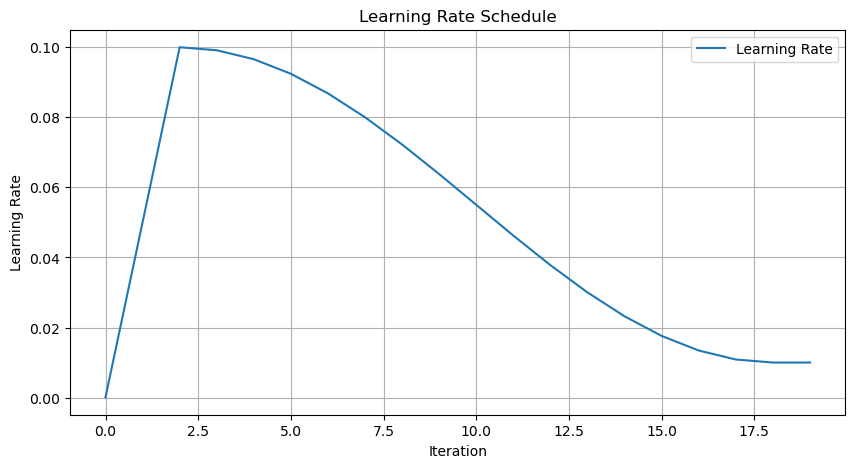

In [4]:
if True: # set to true if you'd like to see a graph of the learning rate schedule
    import matplotlib.pyplot as plt
    
    # Generate learning rate values
    lrs = [scheduler_lambda(i) for i in range(tcfg.max_iters)]
    
    # Plot the learning rates
    plt.figure(figsize=(10, 5))
    plt.plot(lrs, label='Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.xlabel('Iteration')
    plt.ylabel('Learning Rate')
    plt.grid(True)
    plt.legend()
    plt.show()

In [5]:
model, optimizer, log_data = train(
    model, 
    tokenizer, 
    cfg, 
    optimizer,
    scheduler,
    tcfg, 
    train_data_loader,
    test_data_loader,
    #log_data: list = None, 
    #detect_anomoly = False # use if you're getting crazy errors about a the gradient being broken
)

step: 0000, time elapsed: 0.00s, train loss: 6.4519, val loss: 6.4603, ppl: 639, lr: 0.000000, grad norm: 0.0000
step: 0005, time elapsed: 11.15s, train loss: 6.4603, val loss: 6.4539, ppl: 635, lr: 0.000009, grad norm: 0.4258
step: 0010, time elapsed: 22.08s, train loss: 6.4631, val loss: 6.4496, ppl: 632, lr: 0.000006, grad norm: 0.4295
step: 0015, time elapsed: 33.42s, train loss: 6.4565, val loss: 6.4500, ppl: 633, lr: 0.000002, grad norm: 0.4196
step: 0019, time elapsed: 42.47s, train loss: 6.4520, val loss: 6.4536, ppl: 635, lr: 0.000001, grad norm: 0.4089


# inference test before you decide to save it

In [6]:
from inference import generate
prompt = "Once upon a time"
model.eval()
output = generate(
    prompt, 
    model, 
    tokenizer,
    #temperature = 0.9,
    #top_k = 32,
    #top_p = 0.9,
    #max_gen_len = 512,
    #memory_saver_div = 4,
)
model.train()
print(output[0])

Once upon a timeble TimY didG water time star You9 It them every day la W little' uponought sunachotings wanted veryvedtyingsht Heldq smileditedOnce ha hahingjhed


# Saving your final model
if `tcfg.checkpoint_interval != None` then checkpoints have already been saved

you DO still need to do this even if you had been saving checkpoints; the final state has not yet been saved

In [7]:
from tools import save_model
save_model(model, cfg, tcfg, log_data)